https://www.kaggle.com/tharug/ieee-fraud-detection

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import gc # garbage collection

from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', 200)

In [2]:
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ('object', 'category'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            try:
                df[col] = df[col].cat.add_categories('UNK').fillna('UNK')
            except ValueError:
                pass    

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train testデータのユニークなカテゴリカル特徴量の違い

In [3]:
def get_dataset_diff(trn, tst, cat_cols):
    for col in cat_cols:
        train_set = set(trn[col].cat.categories)
        test_set = set(tst[col].cat.categories)
        new_values = len(test_set - train_set)

        if new_values == 0:
            pass
        else:
            print ('**There are {} new values in the test set for the `{}` column'.format(new_values, col))

train中にないtestのカテゴリカル特徴量をUNKにする

In [4]:
def set_valid_cats(trn, test, cat_cols):
    for col in cat_cols:
        cat_values = trn[col].cat.categories
        test[col] = test[col].cat.set_categories(cat_values)
        
        if test[col].isna().sum() > 0:
            print ('Resetting categorical levels created {} null values'.format(test[col].isna().sum()))
        try:
            test[col] = test[col].cat.add_categories('UNK').fillna('UNK')
        except ValueError:
            test[col] = test[col].fillna('UNK')

In [5]:
# Transaction CSVs
train_transaction = pd.read_csv('../input/train_transaction.csv')
test_transaction = pd.read_csv('../input/test_transaction.csv')
# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('../input/train_identity.csv')
test_identity = pd.read_csv('../input/test_identity.csv')
# Sample Submissions
sub = pd.read_csv('../input/sample_submission.csv')

In [6]:
c_cols = [f'C{i}' for i in range(1,15)] # counts (Numeric)
d_cols = [f'D{i}' for i in range(1,16)] # timedeltas (Numeric)
m_cols = [f'M{i}' for i in range(1,10)] # matches (Boolean/ Categorical)
v_cols = [f'V{i}' for i in range(1,340)] # Numeric
id_cols = [f'id_{i:02d}' for i in range(1,39)] # id_12 to id_38 are catergorical columns
id_colC = id_cols[11:]

card_cols = [f'card{i}' for i in range(1,7)]

txn_cat_cols = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + card_cols + m_cols
id_cat_cols = ['DeviceInfo', 'DeviceType'] + id_colC
cat_cols = txn_cat_cols + id_cat_cols

uid_cols=['uid','uid2','uid3']

In [7]:
train=train_transaction.merge(right=train_identity,on='TransactionID',how='left')
test=test_transaction.merge(right=test_identity,on='TransactionID',how='left')

del train_identity, train_transaction, test_transaction, test_identity
gc.collect()

35

In [8]:
train[cat_cols]=train[cat_cols].astype('category')
test[cat_cols]=test[cat_cols].astype('category')

In [9]:
train = reduce_mem_usage2(train)
test = reduce_mem_usage2(test)

Memory usage of dataframe is 1773.32 MB
Memory usage after optimization is: 524.76 MB
Decreased by 70.4%
Memory usage of dataframe is 1517.82 MB
Memory usage after optimization is: 457.64 MB
Decreased by 69.8%


In [10]:
numerical_cols = train.select_dtypes('number').columns
categorical_cols = train.select_dtypes(exclude = 'number').columns

print ('There are {} numerical columns and {} categorical columns'.format(len(numerical_cols), len(categorical_cols)))

There are 385 numerical columns and 49 categorical columns


In [18]:
set_valid_cats(train, test, categorical_cols)

Resetting categorical levels created 9360 null values
Resetting categorical levels created 140 null values
Resetting categorical levels created 46 null values
Resetting categorical levels created 54 null values
Resetting categorical levels created 176 null values
Resetting categorical levels created 47 null values
Resetting categorical levels created 2 null values
Resetting categorical levels created 3 null values
Resetting categorical levels created 6 null values
Resetting categorical levels created 52 null values
Resetting categorical levels created 1 null values
Resetting categorical levels created 5565 null values
Resetting categorical levels created 383 null values
Resetting categorical levels created 2391 null values
Resetting categorical levels created 40 null values
Resetting categorical levels created 8 null values
Resetting categorical levels created 411 null values
Resetting categorical levels created 62 null values
Resetting categorical levels created 17079 null values
Rese

In [25]:
overall_fraud_rate = train['isFraud'].value_counts(normalize = True)[1]
overall_fraud_rate

0.03499000914417313

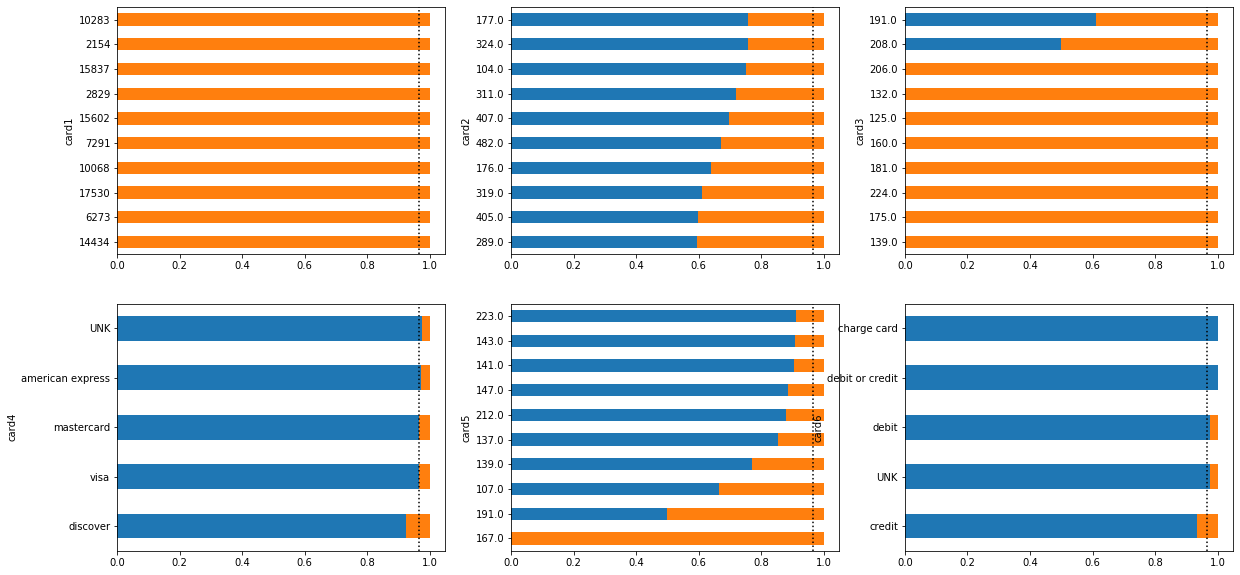

In [43]:
fig, ax = plt.subplots(ncols= 3, nrows= 2, figsize = (20, 10))
ax = ax.ravel()

for i, col in enumerate(card_cols):
    if train[col].dtype.name == 'category':
        props = train.groupby(col, observed = True)['isFraud'].value_counts(dropna = False, normalize=True).unstack()
        props = props.sort_values(by=1, ascending = False).head(10)
        p = props.plot(kind='barh', stacked='True', ax = ax[i], legend = False)
        ax[i].vlines(1 - overall_fraud_rate, ymin= ax[i].get_ylim()[0], ymax= ax[i].get_ylim()[1], linestyle = ':' )
        ax[i].set_ylabel(col)
    else:
        sns.distplot(train[col][train['isFraud'] == 0] ,ax = ax[i], label = 'Not Fraud', hist = False,)
        sns.distplot(train[col][train['isFraud'] == 1] ,ax = ax[i], label = 'Is Fraud', hist = False)
        ax[i].set_xlabel(col)

TransactionAmt特徴量

In [44]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)

    data['D9'] = np.where(data['D9'].isna(),0,1)
    return data

train = addNewFeatures(train)
test = addNewFeatures(test)

train[['uid','uid2','uid3']]=train[['uid','uid2','uid3']].astype('category')
test[['uid','uid2','uid3']]=test[['uid','uid2','uid3']].astype('category')

In [35]:
for col in card_cols+['uid','uid2','uid3']:
    card_count = train[col].value_counts().to_dict()
    train[col+'_count'] = train[col].map(card_count)
    test[col+'_count'] = test[col].map(card_count)

時間特徴量

In [77]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    return df
    
train=setTime(train)
test=setTime(test)

In [109]:
for col in ['DT_hour','DT_day_week','DT_day']:
    fq_encode = train[col].value_counts().to_dict()
            
    train[col+'_freq'] = train[col].map(fq_encode)
    test[col+'_freq']  = test[col].map(fq_encode)

In [120]:
train.drop(['DT','DT_M','DT_W','DT_D'],axis=1,inplace=True)
test.drop(['DT','DT_M','DT_W','DT_D'],axis=1,inplace=True)

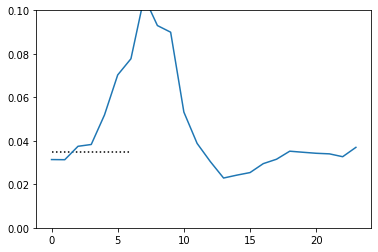

In [90]:
fraud_fracDay = train.groupby('DT_hour')['isFraud'].mean()

plt.plot(fraud_fracDay)
plt.ylim(0.0, 0.1)
plt.hlines(y= overall_fraud_rate, xmin= 0, xmax= 6, linestyles= ':')

(0, 500)

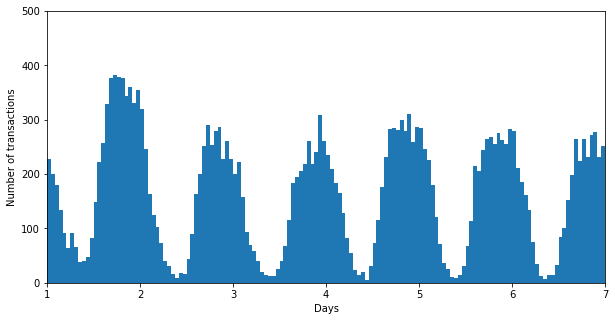

In [47]:
plt.figure(figsize = (10, 5))
vals = plt.hist(train['TransactionDT'] / (3600*24), bins=182*24)
plt.xlim(1, 7)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,500)

(0, 500)

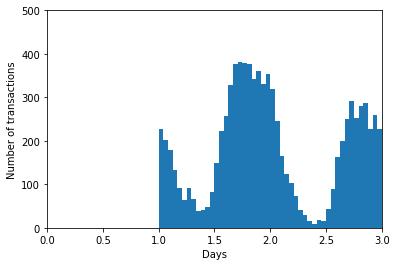

In [53]:
vals = plt.hist(train['TransactionDT'] / (3600*24), bins=182*24)
plt.xlim(0, 3)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,500)

In [54]:
'''
train['TransactionDays'] = train['TransactionDT'] / (60*60*24) - 9/24
test['TransactionDays'] = test['TransactionDT'] / (60*60*24) - 9/24

(0, 500)

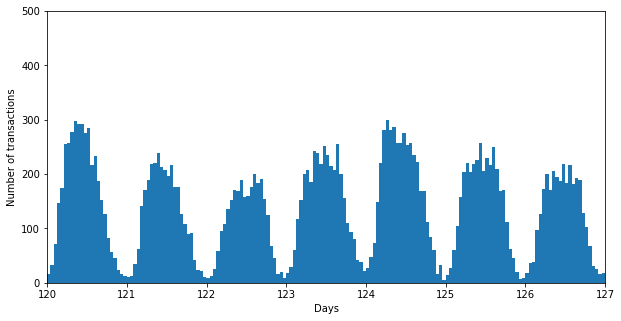

In [56]:
plt.figure(figsize = (10, 5))
vals = plt.hist(train['TransactionDays'], bins=182*24)
plt.xlim(120, 127)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,500)

In [57]:
'''
train['TransactionHour'] = np.floor((train['TransactionDays'] % 1 )* 24)
train['TransactionDayofWeek'] = np.floor(train['TransactionDays'] % 7)

test['TransactionHour'] = np.floor((test['TransactionDays'] % 1 )* 24)
test['TransactionDayofWeek'] = np.floor(test['TransactionDays'] % 7)

In [92]:
'''
# 曜日と時間、頻度の大きさを特徴量に加える
weekday_freq = train['TransactionDayofWeek'].value_counts().to_dict()
train[col+'_weekfreq'] = train['TransactionDayofWeek'].map(weekday_freq)
test[col+'_weekfreq'] = test['TransactionDayofWeek'].map(weekday_freq)

hour_freq = train['TransactionHour'].value_counts().to_dict()
train[col+'_weekfreq'] = train['TransactionDayofWeek'].map(hour_freq)
test[col+'_weekfreq'] = test['TransactionDayofWeek'].map(hour_freq)
'''

"\n# 曜日と時間、頻度の大きさを特徴量に加える\nweekday_freq = train['TransactionDayofWeek'].value_counts().to_dict()\ntrain[col+'_weekfreq'] = train['TransactionDayofWeek'].map(weekday_freq)\ntest[col+'_weekfreq'] = test['TransactionDayofWeek'].map(weekday_freq)\n\nhour_freq = train['TransactionHour'].value_counts().to_dict()\ntrain[col+'_weekfreq'] = train['TransactionDayofWeek'].map(hour_freq)\ntest[col+'_weekfreq'] = test['TransactionDayofWeek'].map(hour_freq)\n"

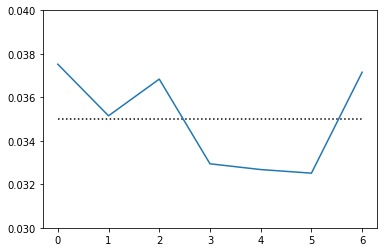

In [79]:
fraud_fracDay = train.groupby('TransactionDayofWeek')['isFraud'].mean()

plt.plot(fraud_fracDay)
plt.ylim(0.03, 0.04)
plt.hlines(y= overall_fraud_rate, xmin= 0, xmax= 6, linestyles= ':')

(0.02, 0.12)

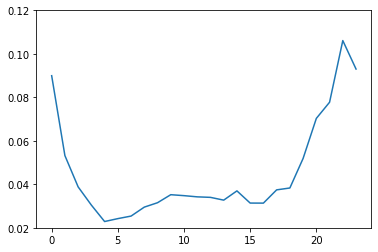

In [80]:
fraud_fracHr = train.groupby('TransactionHour')['isFraud'].mean()

plt.plot(fraud_fracHr)
plt.ylim(0.02, 0.12)

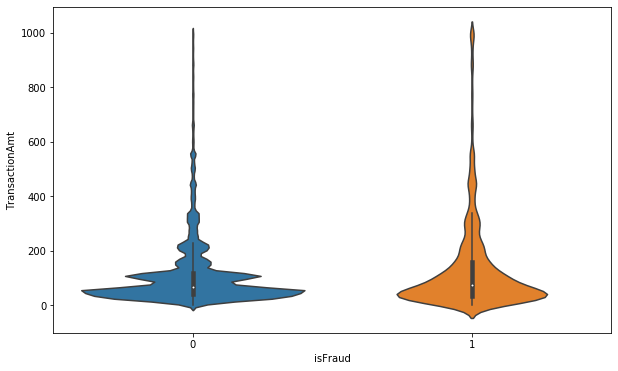

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
plot= sns.violinplot(x = train['isFraud'][train['TransactionAmt'] < 1000], y = train['TransactionAmt'][train['TransactionAmt'] < 1000].astype('float32'))

In [62]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)
        
train = train.replace(np.inf,-999)
test = test.replace(np.inf,-999)

In [68]:
# card特徴量ごとのTransactionAmtの平均値統計量を加える
for col in card_cols+uid_cols:
    if train[col].dtype.name == 'category':
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        transaction_mean = temp_df.groupby(col)['TransactionAmt'].transform('mean')
        train['TransactionAmt_to_mean_'+col] = train['TransactionAmt'] / transaction_mean
        test['TransactionAmt_to_mean_'+col] = test['TransactionAmt'] / transaction_mean        

In [72]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [69]:
numerical_ids = train[id_cols].select_dtypes('number').columns
categorical_ids = train[id_cols].select_dtypes(exclude = 'number').columns

/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


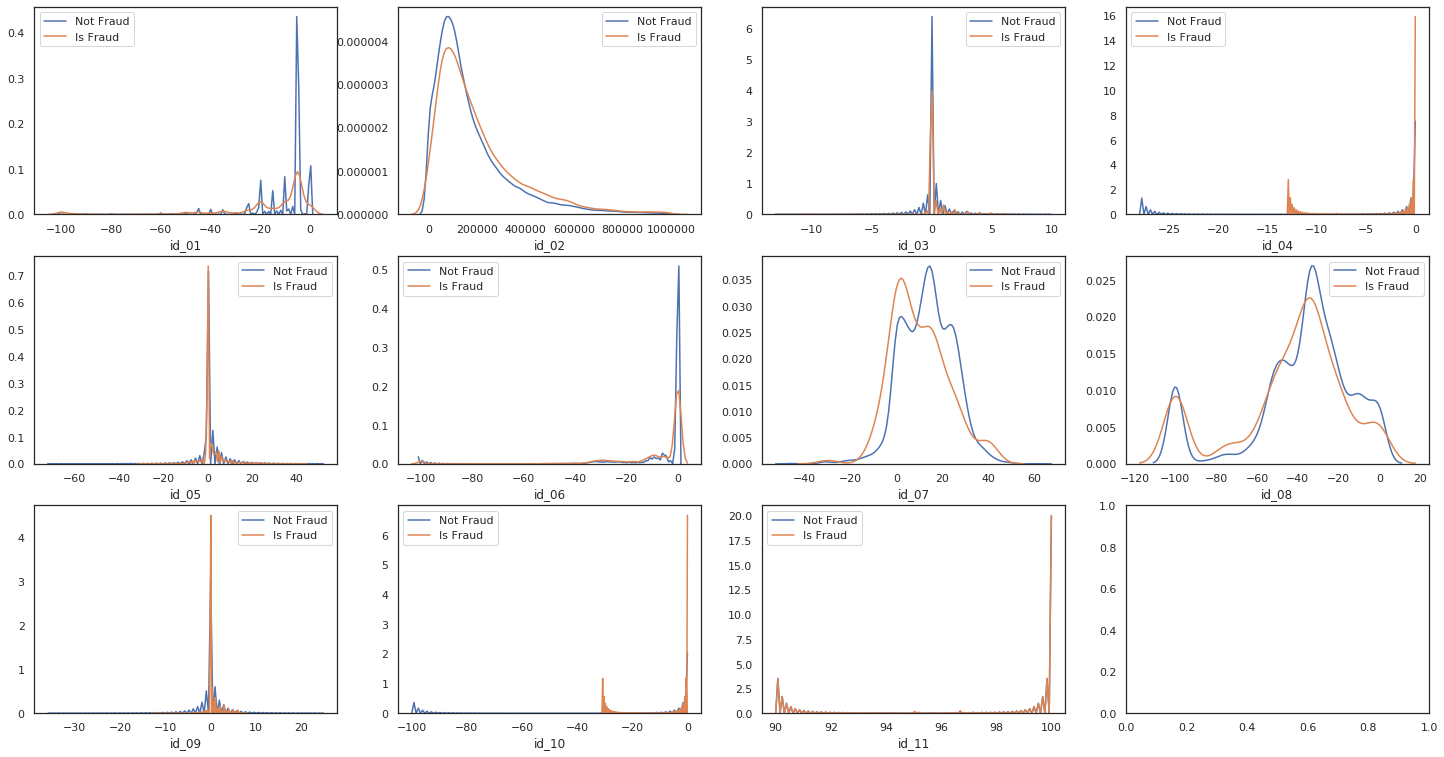

In [97]:
sns.set(style='white')
fig, ax = plt.subplots(ncols= 4, nrows= 3, figsize = (25, 13))
ax = ax.ravel()

for i, col in enumerate(numerical_ids):
        
    sns.distplot(train[col][train['isFraud'] == 0] ,ax = ax[i], label = 'Not Fraud', hist = False)
    sns.distplot(train[col][train['isFraud'] == 1] ,ax = ax[i], label = 'Is Fraud', hist = False)
    ax[i].set_xlabel(col);

In [98]:
# 欠損値補完
train[numerical_ids] = train[numerical_ids].fillna(-999)
test[numerical_ids] = test[numerical_ids].fillna(-999)

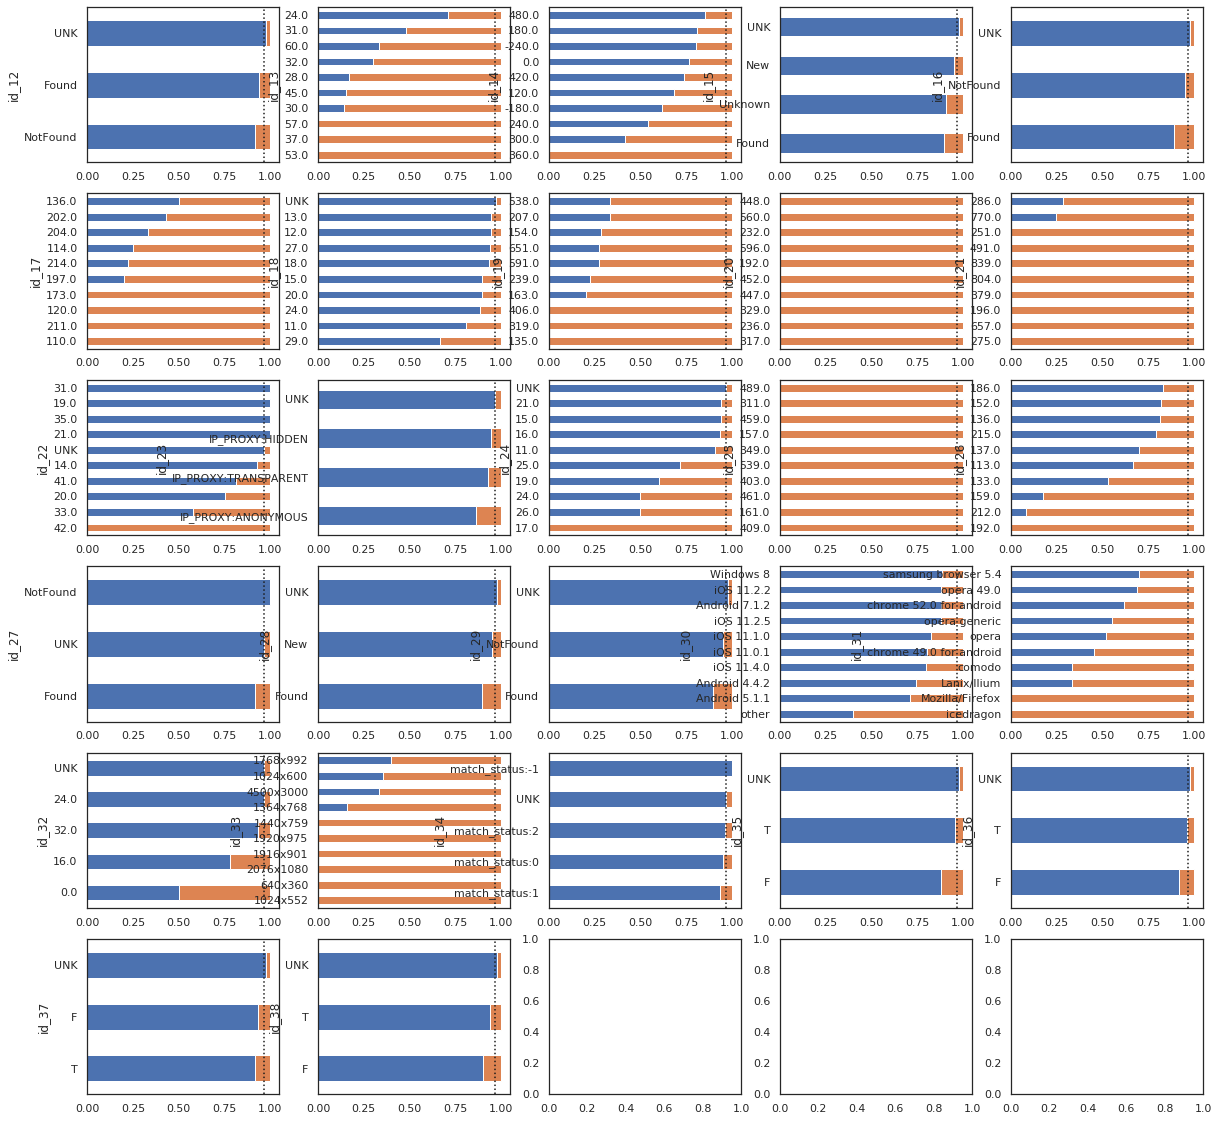

In [99]:
fig, ax = plt.subplots(ncols= 5, nrows= 6, figsize = (20, 20))
ax = ax.ravel()
##scaler = StandardScaler()

for i, col in enumerate(categorical_ids):
    ## if len(train[col].cat.categories) > 10:
        ## print ('column `{}` has more than ten unique levels'.format(col))
    props = train.groupby(col, observed = True)['isFraud'].value_counts(normalize=True).unstack()
    props = props.sort_values(by=1, ascending = False).head(10)
    p = props.plot(kind='barh', stacked='True', ax = ax[i], legend = False)
    ax[i].vlines(1 - overall_fraud_rate, ymin= ax[i].get_ylim()[0], ymax= ax[i].get_ylim()[1], linestyle = ':' )
    ax[i].set_ylabel(col)

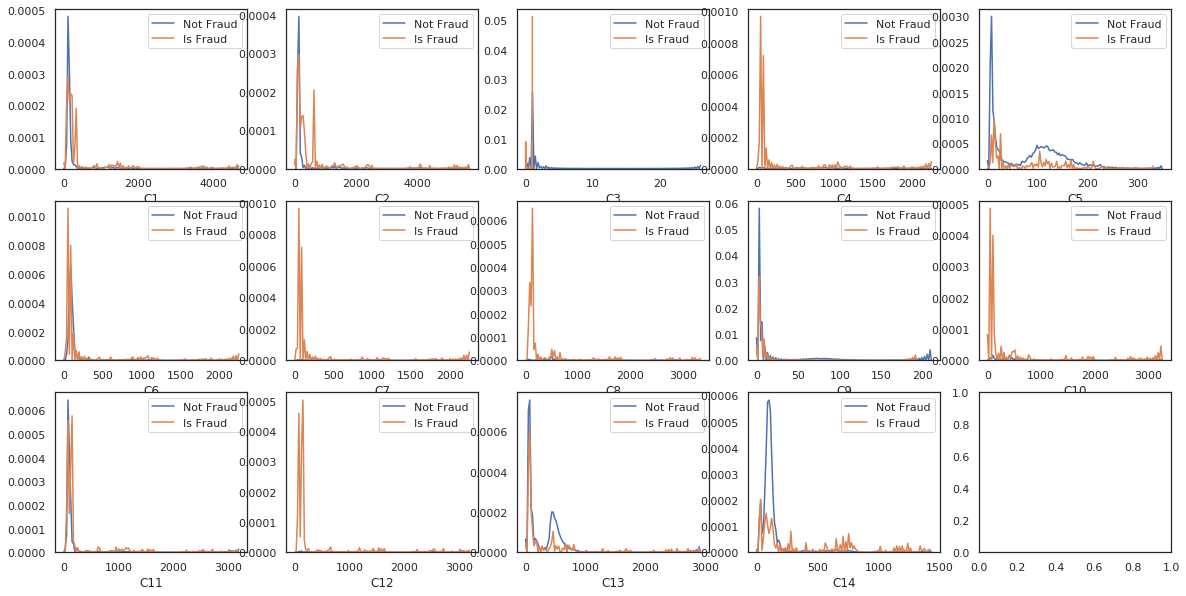

In [106]:
fig, ax = plt.subplots(ncols= 5, nrows= 3, figsize = (20, 10))
ax = ax.ravel()

for i, col in enumerate(c_cols):

    sns.distplot(train[col][train['isFraud'] == 0] ,ax = ax[i], label = 'Not Fraud', hist = False)
    sns.distplot(train[col][train['isFraud'] == 1] ,ax = ax[i], label = 'Is Fraud', hist = False)
    ax[i].set_xlabel(col)

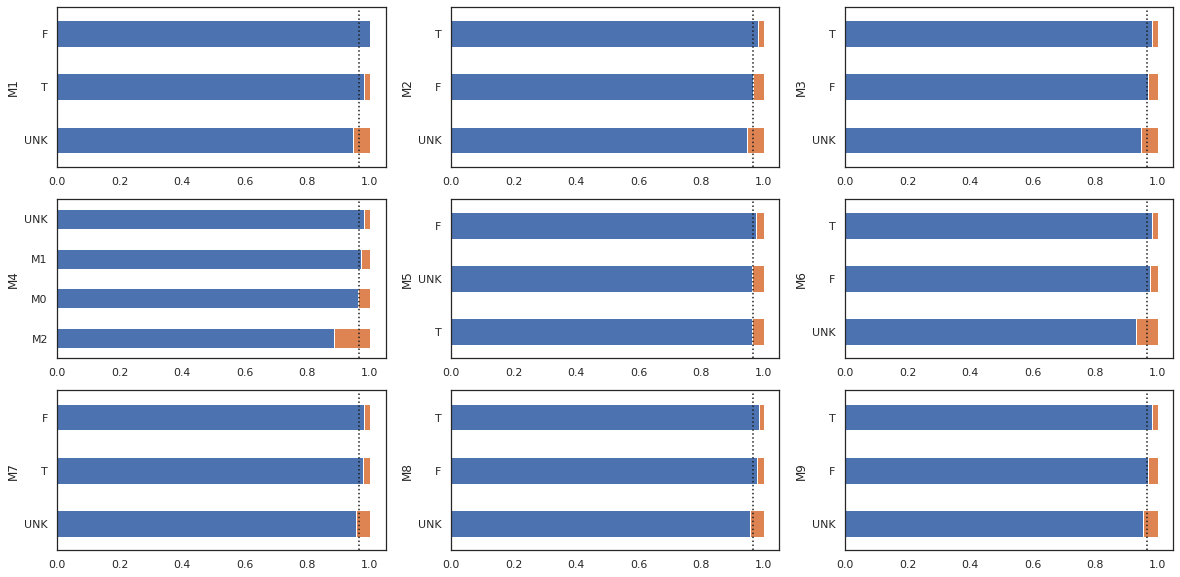

In [111]:
fig, ax = plt.subplots(ncols= 3, nrows= 3, figsize = (20, 10))
ax = ax.ravel()
##scaler = StandardScaler()

for i, col in enumerate(m_cols):
    props = train.groupby(col)['isFraud'].value_counts(normalize=True).unstack()
    props = props.sort_values(by=1, ascending = False)
    p = props.plot(kind='barh', stacked='True', ax = ax[i], legend = False)
    ax[i].vlines(1 - overall_fraud_rate, ymin= ax[i].get_ylim()[0], ymax= ax[i].get_ylim()[1], linestyle = ':' )
    ax[i].set_ylabel(col)

In [127]:
# M特徴量の頻度を特徴量に加える
for col in m_cols:
    count = train[col].value_counts().to_dict()
    train[col+'_count'] = train[col].map(count)
    test[col+'_count'] = test[col].map(count)
    

In [126]:
train['topDomain_P_emaildomain'] = train['P_emaildomain'].str.split('.', expand=True)[0].astype('category')
test['topDomain_P_emaildomain'] = test['P_emaildomain'].str.split('.', expand=True)[0].astype('category')

train_categories = train['topDomain_P_emaildomain'].cat.categories
test['topDomain_P_emaildomain'] = test['topDomain_P_emaildomain'].cat.set_categories(train_categories)

P_email_freq = train['topDomain_P_emaildomain'].value_counts().to_dict()

train['P_topDomain_freq'] = train['topDomain_P_emaildomain'].map(P_email_freq)
test['P_topDomain_freq'] = test['topDomain_P_emaildomain'].map(P_email_freq)

Text(0, 0.5, 'Top Level Domain for Purchaser email')

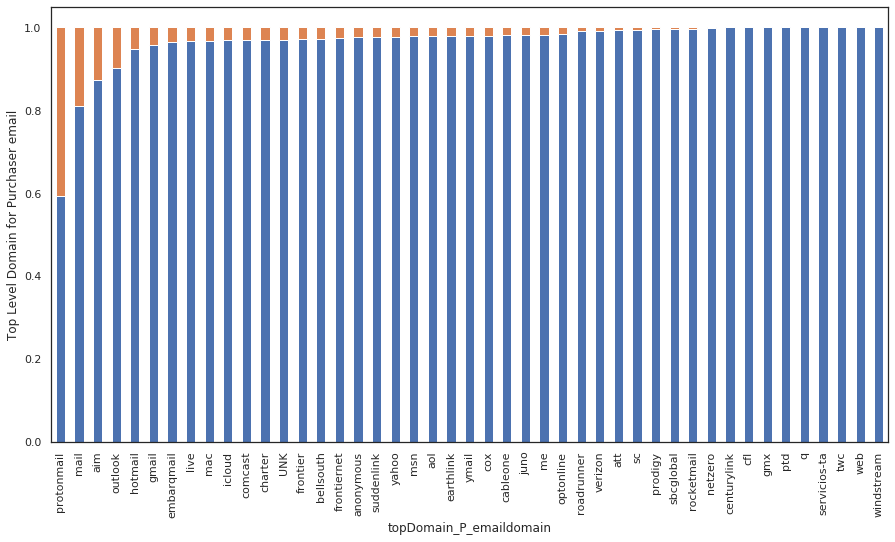

In [117]:
fig, ax = plt.subplots(figsize = (15, 8))
props = train.groupby('topDomain_P_emaildomain')['isFraud'].value_counts(dropna = False, normalize=True).unstack()
props = props.sort_values(by=1, ascending = False).head(50)
p = props.plot(kind='bar', stacked='True', legend = False, ax = ax )
## plt.vlines(1 - overall_fraud_rate, linestyle = ':' )
plt.ylabel('Top Level Domain for Purchaser email')


In [134]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    return df
    
train=setDomain(train)
test=setDomain(test)

In [118]:
train['topDomain_R_emaildomain'] = train['R_emaildomain'].str.split('.', expand=True)[0].astype('category')
test['topDomain_R_emaildomain'] = test['R_emaildomain'].str.split('.', expand=True)[0].astype('category')

train_categories = train['topDomain_R_emaildomain'].cat.categories
test['topDomain_R_emaildomain'] = test['topDomain_R_emaildomain'].cat.set_categories(train_categories)

R_email_freq = train['topDomain_R_emaildomain'].value_counts().to_dict()

train['R_topDomain_freq'] = train['topDomain_R_emaildomain'].map(R_email_freq)
test['R_topDomain_freq'] = test['topDomain_R_emaildomain'].map(R_email_freq)

In [147]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    
    df.loc[df['device_name'].str.contains('UNK', na=False), 'device_name'] = 'UNK'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

In [153]:
for col in ('addr1', 'addr2'):
    count = train[col].value_counts().to_dict()
    train[col+'_freq']  = train[col].map(count)
    test[col+'_freq']  = test[col].map(count)

In [154]:
train['missing_dist1'] = train['dist1'].isna()*1
test['missing_dist1'] = test['dist1'].isna()*1

train['dist1'].fillna(0, inplace = True)
test['dist1'].fillna(0, inplace = True)

train['missing_dist2'] = train['dist2'].isna()*1
test['missing_dist2'] = test['dist2'].isna()*1

train['dist2'].fillna(0, inplace = True)
test['dist2'].fillna(0, inplace = True)

In [155]:
# おそらく重要な特徴量の統計値を追加

group_mean = train.groupby('card1')['isFraud'].transform('mean')
train['V201_card1_mean'] = train['V201']*group_mean
test['V201_card1_mean'] = test['V201']*group_mean

group_dev = train.groupby('card1')['isFraud'].transform('std')
train['V201_card1_std'] = train['V201']*group_dev
test['V201_card1_std'] = test['V201']*group_dev

group_mean = train.groupby('card1')['isFraud'].transform('mean')
train['C1_card1_mean'] = train['C1']*group_mean
test['C1_card1_mean'] = test['C1']*group_mean

group_mean = train.groupby('card1')['isFraud'].transform('mean')
train['C13_card1_mean'] = train['C13']*group_mean
test['C13_card1_mean'] = test['C13']*group_mean

train['card1_addr1'] = train['card1'].astype('str')+ '_' + train['addr1'].astype('str')
test['card1_addr1'] = test['card1'].astype('str')+ '_' + test['addr1'].astype('str')

train['card2_addr1'] = train['card2'].astype('str')+ '_' + train['addr1'].astype('str')
test['card2_addr1'] = test['card2'].astype('str')+ '_' + test['addr1'].astype('str')

group_mean = train.groupby('card1')['isFraud'].transform('mean')
train['dist1_card1_mean'] = train['dist1']*group_mean
test['dist1_card1_mean'] = test['dist1']*group_mean

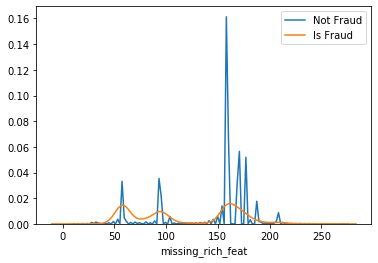

In [156]:
# Vの特徴量が欠損している数を加える
train['missing_rich_feat'] = train[v_cols].isna().sum(axis = 1)
test['missing_rich_feat'] = test[v_cols].isna().sum(axis = 1)

sns.distplot(train['missing_rich_feat'][train['isFraud'] == 0], label = 'Not Fraud', hist = False)
sns.distplot(train['missing_rich_feat'][train['isFraud'] == 1], label = 'Is Fraud', hist = False)

In [194]:
i_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'dist1','dist2',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3']

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [157]:
train[v_cols] = train[v_cols].fillna(-1)
test[v_cols] = test[v_cols].fillna(-1)

In [158]:
train[d_cols]  = train[d_cols].fillna(-1)
test[d_cols]  = test[d_cols].fillna(-1)

In [181]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

In [196]:
train = train.sort_values(by = 'TransactionDT')
test = test.sort_values(by = 'TransactionDT')

In [206]:
features = [col for col in train.columns if col != 'isFraud']
X_train = train[features].copy()
X_test = test[features].copy()

y_train = train['isFraud']

#del train, test
#gc.collect()

X_train_ids = X_train[['TransactionID']].copy()
X_test_ids = X_test[['TransactionID']].copy()

X_train.drop(columns = 'TransactionID', inplace = True)
X_test.drop(columns = 'TransactionID', inplace = True)

In [207]:
categorical_cols = X_train.select_dtypes(exclude = 'number').columns
categorical_cols

Index(['ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1',
       'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'uid', 'uid2', 'uid3', 'topDomain_P_emaildomain',
       'device_name', 'card1_addr1', 'card2_addr1'],
      dtype='object')

In [208]:
from category_encoders import TargetEncoder
target_encoder = TargetEncoder(cols= categorical_cols.tolist(), smoothing = 10, return_df= True)
X_train = target_encoder.fit_transform(X = X_train, y = y_train)
X_test = target_encoder.transform(X = X_test)

In [209]:
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 1133.12 MB
Memory usage after optimization is: 701.16 MB
Decreased by 38.1%
Memory usage of dataframe is 979.97 MB
Memory usage after optimization is: 609.72 MB
Decreased by 37.8%


In [213]:
y_train.to_pickle('data/y_train.pkl')

In [212]:
X_train.to_pickle('data/X_train1.pkl')
X_test.to_pickle('data/X_test1.pkl')

### デフォルト特徴量

In [201]:
import lightgbm as lgb
# import xgboost as xgb
# from xgboost import plot_importance
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from hyperopt import space_eval

from scipy.stats import uniform
from time import time
import datetime

In [202]:
pos_weight = sum(y_train == 0) / sum(y_train == 1)
pos_weight

params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators' : 1000,
    'boosting_type': 'gbdt',
    'num_leaves': 256,
    'min_data_in_leaf': 40,
    'max_depth': 20,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.7,
    'lambda_l1': 0.6,
    'lambda_l2': 1.10,
    'scale_pos_weight': pos_weight}

In [159]:
splits = 5
folds = TimeSeriesSplit(n_splits=splits)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="auc",
            early_stopping_rounds=100,
            verbose= 500)
    del X_trn, y_trn
    
    val=clf.predict_proba(X_val)[:,1]
    
    feature_importances['fold_{}'.format(fold_n + 1)] = clf.feature_importances_
    
    del clf, X_val
    print('ROC accuracy: {}'.format(roc_auc_score(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	training's auc: 1	valid_1's auc: 0.947087
ROC accuracy: 0.9470866207478289
fold completed in 17.180920600891113s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[163]	training's auc: 1	valid_1's auc: 0.962543
ROC accuracy: 0.9625434171712001
fold completed in 42.40656232833862s
** Training fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[276]	training's auc: 1	valid_1's auc: 0.957846
ROC accuracy: 0.9578460983206494
fold completed in 79.68653106689453s
** Training fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[371]	training's auc: 1	valid_1's auc: 0.967918
ROC accuracy: 0.9679176651544068
fold completed in 131.32063817977905s
** Training fold 5
Training until validation scores don't i

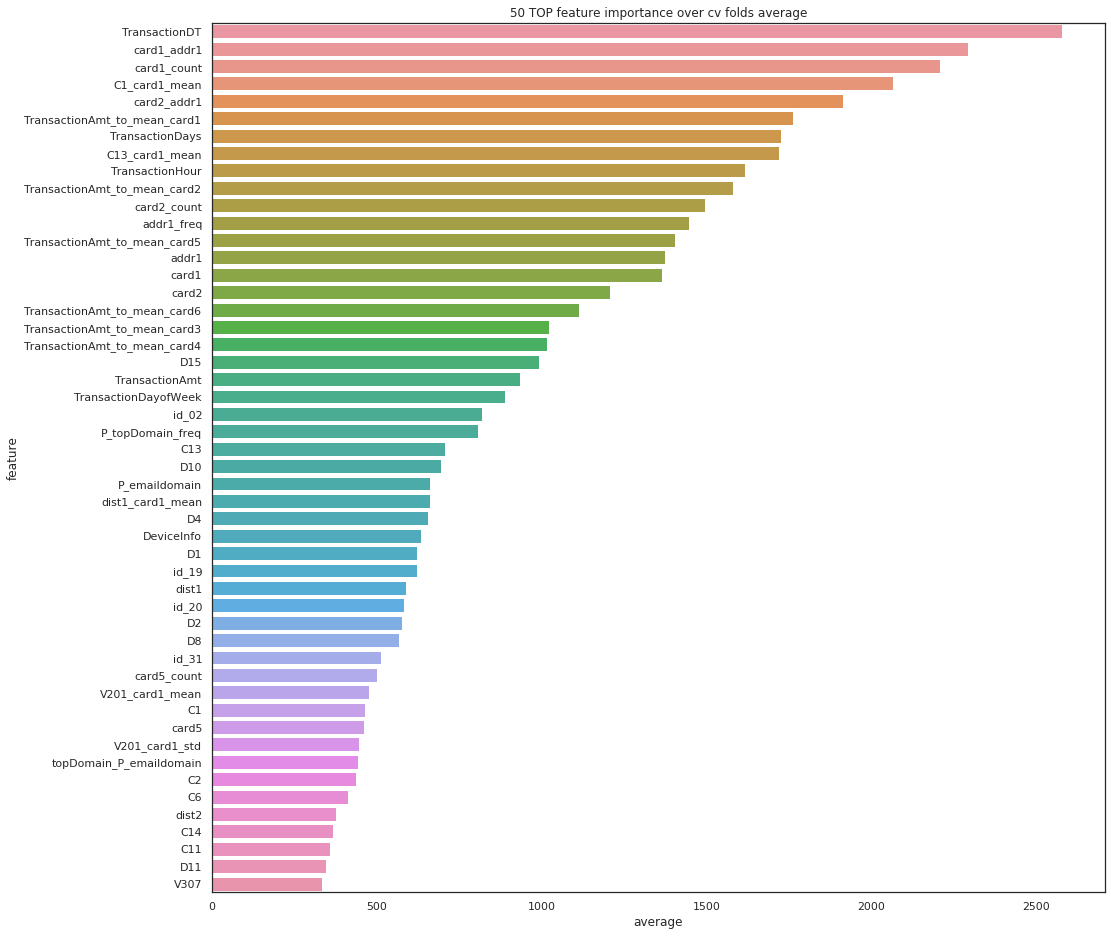

In [160]:
feature_importances['average'] = feature_importances.mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');

### 追加特徴量

In [203]:
splits = 5
folds = TimeSeriesSplit(n_splits=splits)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="auc",
            early_stopping_rounds=100,
            verbose= 500)
    del X_trn, y_trn
    
    val=clf.predict_proba(X_val)[:,1]
    
    feature_importances['fold_{}'.format(fold_n + 1)] = clf.feature_importances_
    
    del clf, X_val
    print('ROC accuracy: {}'.format(roc_auc_score(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	training's auc: 1	valid_1's auc: 0.950975
ROC accuracy: 0.9509749895192668
fold completed in 21.499669313430786s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	training's auc: 1	valid_1's auc: 0.964452
ROC accuracy: 0.9644522933335862
fold completed in 43.37918138504028s
** Training fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[255]	training's auc: 1	valid_1's auc: 0.960486
ROC accuracy: 0.9604861196938098
fold completed in 94.30871272087097s
** Training fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[348]	training's auc: 1	valid_1's auc: 0.969758
ROC accuracy: 0.9697582233697423
fold completed in 151.7461040019989s
** Training fold 5
Training until validation scores don't im

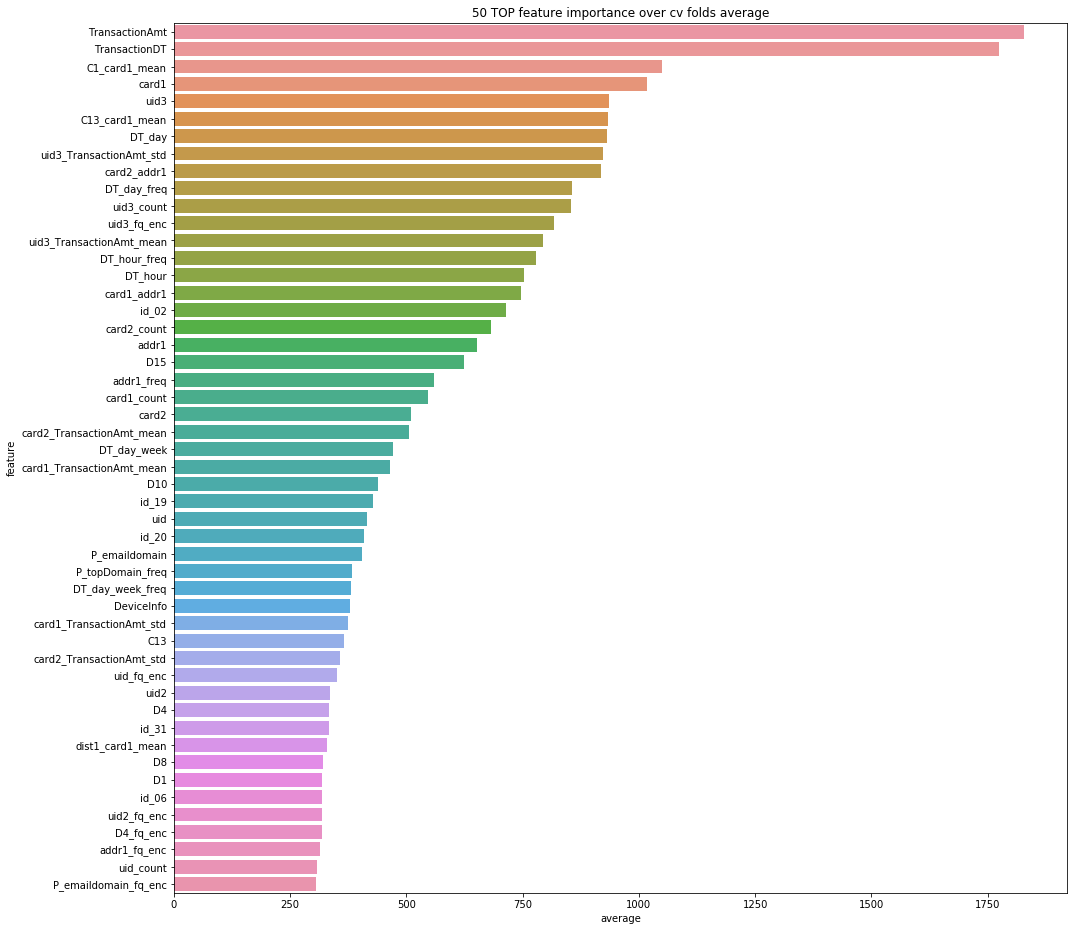

In [204]:
feature_importances['average'] = feature_importances.mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');